# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.6429
Epoch 1/200, Iteration 2/12, Loss: 0.4076
Epoch 1/200, Iteration 3/12, Loss: 0.3222
Epoch 1/200, Iteration 4/12, Loss: 0.3563
Epoch 1/200, Iteration 5/12, Loss: 0.4523
Epoch 1/200, Iteration 6/12, Loss: 0.3401
Epoch 1/200, Iteration 7/12, Loss: 0.3616
Epoch 1/200, Iteration 8/12, Loss: 0.3155
Epoch 1/200, Iteration 9/12, Loss: 0.2832
Epoch 1/200, Iteration 10/12, Loss: 0.2526
Epoch 1/200, Iteration 11/12, Loss: 0.1951
Epoch 1/200, Iteration 12/12, Loss: 0.1850
Epoch 1/200, Iteration 13/12, Loss: 0.2451
Train Error: 
 Accuracy: 78.0%, Avg loss: 0.268205, MRE: 0.184165, MAE: 0.031391 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.276335, MRE: 0.164976, MAE: 0.031328 

Epoch 2/200, Iteration 1/12, Loss: 0.2687
Epoch 2/200, Iteration 2/12, Loss: 0.2576
Epoch 2/200, Iteration 3/12, Loss: 0.3034
Epoch 2/200, Iteration 4/12, Loss: 0.2617
Epoch 2/200, Iteration 5/12, Loss: 0.2798
Epoch 2/200, Iteration 6/12, Loss: 0.1785
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.091109, MRE: 0.068615, MAE: 0.012403 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.079313, MRE: 0.056497, MAE: 0.010593 

Epoch 13/200, Iteration 1/12, Loss: 0.0857
Epoch 13/200, Iteration 2/12, Loss: 0.0777
Epoch 13/200, Iteration 3/12, Loss: 0.0888
Epoch 13/200, Iteration 4/12, Loss: 0.0972
Epoch 13/200, Iteration 5/12, Loss: 0.0838
Epoch 13/200, Iteration 6/12, Loss: 0.0705
Epoch 13/200, Iteration 7/12, Loss: 0.0971
Epoch 13/200, Iteration 8/12, Loss: 0.0980
Epoch 13/200, Iteration 9/12, Loss: 0.1100
Epoch 13/200, Iteration 10/12, Loss: 0.0999
Epoch 13/200, Iteration 11/12, Loss: 0.0722
Epoch 13/200, Iteration 12/12, Loss: 0.0675
Epoch 13/200, Iteration 13/12, Loss: 0.0796
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.087501, MRE: 0.055348, MAE: 0.010924 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.076637, MRE: 0.043040, MAE: 0.009527 

Epoch 14/200, Iteration 1/12, Loss: 0.0806
Epoch 14/200, Iteration 2/12, Loss: 0.0965
Epoch 14/200, Itera

Train Error: 
 Accuracy: 90.25%, Avg loss: 0.057838, MRE: 0.053820, MAE: 0.006602 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.058025, MRE: 0.045535, MAE: 0.006315 

Epoch 25/200, Iteration 1/12, Loss: 0.0920
Epoch 25/200, Iteration 2/12, Loss: 0.0578
Epoch 25/200, Iteration 3/12, Loss: 0.0552
Epoch 25/200, Iteration 4/12, Loss: 0.0486
Epoch 25/200, Iteration 5/12, Loss: 0.0555
Epoch 25/200, Iteration 6/12, Loss: 0.0518
Epoch 25/200, Iteration 7/12, Loss: 0.0593
Epoch 25/200, Iteration 8/12, Loss: 0.0543
Epoch 25/200, Iteration 9/12, Loss: 0.0591
Epoch 25/200, Iteration 10/12, Loss: 0.0623
Epoch 25/200, Iteration 11/12, Loss: 0.0497
Epoch 25/200, Iteration 12/12, Loss: 0.0485
Epoch 25/200, Iteration 13/12, Loss: 0.0380
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.052831, MRE: 0.043364, MAE: 0.006220 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.044611, MRE: 0.033607, MAE: 0.005227 

Epoch 26/200, Iteration 1/12, Loss: 0.0518
Epoch 26/200, Iteration 2/12, Loss: 0.0699
Epoch 26/200, Itera

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.056540, MRE: 0.041367, MAE: 0.007582 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.050321, MRE: 0.033141, MAE: 0.006549 

Epoch 37/200, Iteration 1/12, Loss: 0.0517
Epoch 37/200, Iteration 2/12, Loss: 0.0427
Epoch 37/200, Iteration 3/12, Loss: 0.0615
Epoch 37/200, Iteration 4/12, Loss: 0.0482
Epoch 37/200, Iteration 5/12, Loss: 0.0444
Epoch 37/200, Iteration 6/12, Loss: 0.0373
Epoch 37/200, Iteration 7/12, Loss: 0.0436
Epoch 37/200, Iteration 8/12, Loss: 0.0374
Epoch 37/200, Iteration 9/12, Loss: 0.0506
Epoch 37/200, Iteration 10/12, Loss: 0.0435
Epoch 37/200, Iteration 11/12, Loss: 0.0428
Epoch 37/200, Iteration 12/12, Loss: 0.0461
Epoch 37/200, Iteration 13/12, Loss: 0.0380
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.037841, MRE: 0.029207, MAE: 0.004525 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.030499, MRE: 0.022658, MAE: 0.003695 

Epoch 38/200, Iteration 1/12, Loss: 0.0282
Epoch 38/200, Iteration 2/12, Loss: 0.0440
Epoch 38/200, Iterat

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.034563, MRE: 0.025479, MAE: 0.004077 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.031698, MRE: 0.021261, MAE: 0.003671 

Epoch 49/200, Iteration 1/12, Loss: 0.0330
Epoch 49/200, Iteration 2/12, Loss: 0.0473
Epoch 49/200, Iteration 3/12, Loss: 0.0283
Epoch 49/200, Iteration 4/12, Loss: 0.0268
Epoch 49/200, Iteration 5/12, Loss: 0.0361
Epoch 49/200, Iteration 6/12, Loss: 0.0247
Epoch 49/200, Iteration 7/12, Loss: 0.0273
Epoch 49/200, Iteration 8/12, Loss: 0.0321
Epoch 49/200, Iteration 9/12, Loss: 0.0293
Epoch 49/200, Iteration 10/12, Loss: 0.0425
Epoch 49/200, Iteration 11/12, Loss: 0.0347
Epoch 49/200, Iteration 12/12, Loss: 0.0476
Epoch 49/200, Iteration 13/12, Loss: 0.0458
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.035125, MRE: 0.026487, MAE: 0.004146 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.030523, MRE: 0.020693, MAE: 0.003606 

Epoch 50/200, Iteration 1/12, Loss: 0.0395
Epoch 50/200, Iteration 2/12, Loss: 0.0269
Epoch 50/200, Itera

Train Error: 
 Accuracy: 96.25%, Avg loss: 0.031854, MRE: 0.023994, MAE: 0.003778 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.028658, MRE: 0.019716, MAE: 0.003379 

Epoch 61/200, Iteration 1/12, Loss: 0.0331
Epoch 61/200, Iteration 2/12, Loss: 0.0248
Epoch 61/200, Iteration 3/12, Loss: 0.0286
Epoch 61/200, Iteration 4/12, Loss: 0.0373
Epoch 61/200, Iteration 5/12, Loss: 0.0255
Epoch 61/200, Iteration 6/12, Loss: 0.0440
Epoch 61/200, Iteration 7/12, Loss: 0.0455
Epoch 61/200, Iteration 8/12, Loss: 0.0194
Epoch 61/200, Iteration 9/12, Loss: 0.0225
Epoch 61/200, Iteration 10/12, Loss: 0.0441
Epoch 61/200, Iteration 11/12, Loss: 0.0313
Epoch 61/200, Iteration 12/12, Loss: 0.0315
Epoch 61/200, Iteration 13/12, Loss: 0.0506
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.032820, MRE: 0.023754, MAE: 0.003921 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.029609, MRE: 0.019922, MAE: 0.003492 

Epoch 62/200, Iteration 1/12, Loss: 0.0349
Epoch 62/200, Iteration 2/12, Loss: 0.0262
Epoch 62/200, Itera

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.031757, MRE: 0.023412, MAE: 0.003782 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.028139, MRE: 0.018863, MAE: 0.003313 

Epoch 73/200, Iteration 1/12, Loss: 0.0434
Epoch 73/200, Iteration 2/12, Loss: 0.0474
Epoch 73/200, Iteration 3/12, Loss: 0.0473
Epoch 73/200, Iteration 4/12, Loss: 0.0247
Epoch 73/200, Iteration 5/12, Loss: 0.0242
Epoch 73/200, Iteration 6/12, Loss: 0.0277
Epoch 73/200, Iteration 7/12, Loss: 0.0242
Epoch 73/200, Iteration 8/12, Loss: 0.0334
Epoch 73/200, Iteration 9/12, Loss: 0.0270
Epoch 73/200, Iteration 10/12, Loss: 0.0343
Epoch 73/200, Iteration 11/12, Loss: 0.0252
Epoch 73/200, Iteration 12/12, Loss: 0.0383
Epoch 73/200, Iteration 13/12, Loss: 0.0230
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.033288, MRE: 0.024121, MAE: 0.003999 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.029519, MRE: 0.019873, MAE: 0.003504 

Epoch 74/200, Iteration 1/12, Loss: 0.0387
Epoch 74/200, Iteration 2/12, Loss: 0.0318
Epoch 74/200, Iterat

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.030575, MRE: 0.022727, MAE: 0.003620 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027510, MRE: 0.018475, MAE: 0.003221 

Epoch 85/200, Iteration 1/12, Loss: 0.0445
Epoch 85/200, Iteration 2/12, Loss: 0.0232
Epoch 85/200, Iteration 3/12, Loss: 0.0260
Epoch 85/200, Iteration 4/12, Loss: 0.0381
Epoch 85/200, Iteration 5/12, Loss: 0.0334
Epoch 85/200, Iteration 6/12, Loss: 0.0403
Epoch 85/200, Iteration 7/12, Loss: 0.0320
Epoch 85/200, Iteration 8/12, Loss: 0.0265
Epoch 85/200, Iteration 9/12, Loss: 0.0307
Epoch 85/200, Iteration 10/12, Loss: 0.0226
Epoch 85/200, Iteration 11/12, Loss: 0.0279
Epoch 85/200, Iteration 12/12, Loss: 0.0265
Epoch 85/200, Iteration 13/12, Loss: 0.0291
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030496, MRE: 0.022716, MAE: 0.003613 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027051, MRE: 0.018296, MAE: 0.003174 

Epoch 86/200, Iteration 1/12, Loss: 0.0271
Epoch 86/200, Iteration 2/12, Loss: 0.0253
Epoch 86/200, Iterat

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030750, MRE: 0.022735, MAE: 0.003641 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027174, MRE: 0.018239, MAE: 0.003185 

Epoch 97/200, Iteration 1/12, Loss: 0.0254
Epoch 97/200, Iteration 2/12, Loss: 0.0394
Epoch 97/200, Iteration 3/12, Loss: 0.0240
Epoch 97/200, Iteration 4/12, Loss: 0.0407
Epoch 97/200, Iteration 5/12, Loss: 0.0236
Epoch 97/200, Iteration 6/12, Loss: 0.0258
Epoch 97/200, Iteration 7/12, Loss: 0.0238
Epoch 97/200, Iteration 8/12, Loss: 0.0504
Epoch 97/200, Iteration 9/12, Loss: 0.0193
Epoch 97/200, Iteration 10/12, Loss: 0.0365
Epoch 97/200, Iteration 11/12, Loss: 0.0307
Epoch 97/200, Iteration 12/12, Loss: 0.0299
Epoch 97/200, Iteration 13/12, Loss: 0.0259
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030951, MRE: 0.022843, MAE: 0.003653 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027144, MRE: 0.018242, MAE: 0.003180 

Epoch 98/200, Iteration 1/12, Loss: 0.0318
Epoch 98/200, Iteration 2/12, Loss: 0.0349
Epoch 98/200, Iterati

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030303, MRE: 0.022714, MAE: 0.003591 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027052, MRE: 0.018198, MAE: 0.003171 

Epoch 109/200, Iteration 1/12, Loss: 0.0272
Epoch 109/200, Iteration 2/12, Loss: 0.0431
Epoch 109/200, Iteration 3/12, Loss: 0.0236
Epoch 109/200, Iteration 4/12, Loss: 0.0382
Epoch 109/200, Iteration 5/12, Loss: 0.0336
Epoch 109/200, Iteration 6/12, Loss: 0.0233
Epoch 109/200, Iteration 7/12, Loss: 0.0407
Epoch 109/200, Iteration 8/12, Loss: 0.0238
Epoch 109/200, Iteration 9/12, Loss: 0.0271
Epoch 109/200, Iteration 10/12, Loss: 0.0267
Epoch 109/200, Iteration 11/12, Loss: 0.0219
Epoch 109/200, Iteration 12/12, Loss: 0.0401
Epoch 109/200, Iteration 13/12, Loss: 0.0261
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030592, MRE: 0.023231, MAE: 0.003624 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027066, MRE: 0.018216, MAE: 0.003172 

Epoch 110/200, Iteration 1/12, Loss: 0.0210
Epoch 110/200, Iteration 2/12, Loss: 0.0333
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030509, MRE: 0.023071, MAE: 0.003607 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027112, MRE: 0.018244, MAE: 0.003176 

Epoch 121/200, Iteration 1/12, Loss: 0.0518
Epoch 121/200, Iteration 2/12, Loss: 0.0229
Epoch 121/200, Iteration 3/12, Loss: 0.0326
Epoch 121/200, Iteration 4/12, Loss: 0.0208
Epoch 121/200, Iteration 5/12, Loss: 0.0284
Epoch 121/200, Iteration 6/12, Loss: 0.0237
Epoch 121/200, Iteration 7/12, Loss: 0.0236
Epoch 121/200, Iteration 8/12, Loss: 0.0500
Epoch 121/200, Iteration 9/12, Loss: 0.0287
Epoch 121/200, Iteration 10/12, Loss: 0.0361
Epoch 121/200, Iteration 11/12, Loss: 0.0225
Epoch 121/200, Iteration 12/12, Loss: 0.0254
Epoch 121/200, Iteration 13/12, Loss: 0.0311
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030097, MRE: 0.022631, MAE: 0.003566 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027109, MRE: 0.018240, MAE: 0.003176 

Epoch 122/200, Iteration 1/12, Loss: 0.0384
Epoch 122/200, Iteration 2/12, Loss: 0.0234
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030208, MRE: 0.022804, MAE: 0.003571 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027110, MRE: 0.018238, MAE: 0.003176 

Epoch 133/200, Iteration 1/12, Loss: 0.0296
Epoch 133/200, Iteration 2/12, Loss: 0.0255
Epoch 133/200, Iteration 3/12, Loss: 0.0383
Epoch 133/200, Iteration 4/12, Loss: 0.0356
Epoch 133/200, Iteration 5/12, Loss: 0.0238
Epoch 133/200, Iteration 6/12, Loss: 0.0239
Epoch 133/200, Iteration 7/12, Loss: 0.0391
Epoch 133/200, Iteration 8/12, Loss: 0.0463
Epoch 133/200, Iteration 9/12, Loss: 0.0342
Epoch 133/200, Iteration 10/12, Loss: 0.0206
Epoch 133/200, Iteration 11/12, Loss: 0.0270
Epoch 133/200, Iteration 12/12, Loss: 0.0246
Epoch 133/200, Iteration 13/12, Loss: 0.0270
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030449, MRE: 0.022668, MAE: 0.003603 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027109, MRE: 0.018237, MAE: 0.003176 

Epoch 134/200, Iteration 1/12, Loss: 0.0297
Epoch 134/200, Iteration 2/12, Loss: 0.0345
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030440, MRE: 0.022752, MAE: 0.003605 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 145/200, Iteration 1/12, Loss: 0.0412
Epoch 145/200, Iteration 2/12, Loss: 0.0241
Epoch 145/200, Iteration 3/12, Loss: 0.0197
Epoch 145/200, Iteration 4/12, Loss: 0.0337
Epoch 145/200, Iteration 5/12, Loss: 0.0281
Epoch 145/200, Iteration 6/12, Loss: 0.0345
Epoch 145/200, Iteration 7/12, Loss: 0.0187
Epoch 145/200, Iteration 8/12, Loss: 0.0265
Epoch 145/200, Iteration 9/12, Loss: 0.0329
Epoch 145/200, Iteration 10/12, Loss: 0.0253
Epoch 145/200, Iteration 11/12, Loss: 0.0424
Epoch 145/200, Iteration 12/12, Loss: 0.0368
Epoch 145/200, Iteration 13/12, Loss: 0.0362
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.031082, MRE: 0.023157, MAE: 0.003672 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 146/200, Iteration 1/12, Loss: 0.0292
Epoch 146/200, Iteration 2/12, Loss: 0.0343
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030582, MRE: 0.022857, MAE: 0.003621 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 157/200, Iteration 1/12, Loss: 0.0281
Epoch 157/200, Iteration 2/12, Loss: 0.0240
Epoch 157/200, Iteration 3/12, Loss: 0.0213
Epoch 157/200, Iteration 4/12, Loss: 0.0317
Epoch 157/200, Iteration 5/12, Loss: 0.0255
Epoch 157/200, Iteration 6/12, Loss: 0.0265
Epoch 157/200, Iteration 7/12, Loss: 0.0361
Epoch 157/200, Iteration 8/12, Loss: 0.0254
Epoch 157/200, Iteration 9/12, Loss: 0.0270
Epoch 157/200, Iteration 10/12, Loss: 0.0349
Epoch 157/200, Iteration 11/12, Loss: 0.0369
Epoch 157/200, Iteration 12/12, Loss: 0.0418
Epoch 157/200, Iteration 13/12, Loss: 0.0456
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030291, MRE: 0.022704, MAE: 0.003586 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 158/200, Iteration 1/12, Loss: 0.0198
Epoch 158/200, Iteration 2/12, Loss: 0.0525
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.031038, MRE: 0.023011, MAE: 0.003662 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018233, MAE: 0.003175 

Epoch 169/200, Iteration 1/12, Loss: 0.0292
Epoch 169/200, Iteration 2/12, Loss: 0.0282
Epoch 169/200, Iteration 3/12, Loss: 0.0219
Epoch 169/200, Iteration 4/12, Loss: 0.0395
Epoch 169/200, Iteration 5/12, Loss: 0.0272
Epoch 169/200, Iteration 6/12, Loss: 0.0238
Epoch 169/200, Iteration 7/12, Loss: 0.0310
Epoch 169/200, Iteration 8/12, Loss: 0.0214
Epoch 169/200, Iteration 9/12, Loss: 0.0377
Epoch 169/200, Iteration 10/12, Loss: 0.0312
Epoch 169/200, Iteration 11/12, Loss: 0.0321
Epoch 169/200, Iteration 12/12, Loss: 0.0428
Epoch 169/200, Iteration 13/12, Loss: 0.0321
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030767, MRE: 0.022932, MAE: 0.003647 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018233, MAE: 0.003175 

Epoch 170/200, Iteration 1/12, Loss: 0.0356
Epoch 170/200, Iteration 2/12, Loss: 0.0290
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030410, MRE: 0.022884, MAE: 0.003600 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 181/200, Iteration 1/12, Loss: 0.0250
Epoch 181/200, Iteration 2/12, Loss: 0.0238
Epoch 181/200, Iteration 3/12, Loss: 0.0238
Epoch 181/200, Iteration 4/12, Loss: 0.0235
Epoch 181/200, Iteration 5/12, Loss: 0.0366
Epoch 181/200, Iteration 6/12, Loss: 0.0278
Epoch 181/200, Iteration 7/12, Loss: 0.0323
Epoch 181/200, Iteration 8/12, Loss: 0.0373
Epoch 181/200, Iteration 9/12, Loss: 0.0476
Epoch 181/200, Iteration 10/12, Loss: 0.0269
Epoch 181/200, Iteration 11/12, Loss: 0.0302
Epoch 181/200, Iteration 12/12, Loss: 0.0348
Epoch 181/200, Iteration 13/12, Loss: 0.0247
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030872, MRE: 0.022833, MAE: 0.003652 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 182/200, Iteration 1/12, Loss: 0.0234
Epoch 182/200, Iteration 2/12, Loss: 0.0280
Epoch 

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030128, MRE: 0.022868, MAE: 0.003570 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 193/200, Iteration 1/12, Loss: 0.0335
Epoch 193/200, Iteration 2/12, Loss: 0.0305
Epoch 193/200, Iteration 3/12, Loss: 0.0284
Epoch 193/200, Iteration 4/12, Loss: 0.0323
Epoch 193/200, Iteration 5/12, Loss: 0.0359
Epoch 193/200, Iteration 6/12, Loss: 0.0261
Epoch 193/200, Iteration 7/12, Loss: 0.0189
Epoch 193/200, Iteration 8/12, Loss: 0.0347
Epoch 193/200, Iteration 9/12, Loss: 0.0367
Epoch 193/200, Iteration 10/12, Loss: 0.0462
Epoch 193/200, Iteration 11/12, Loss: 0.0213
Epoch 193/200, Iteration 12/12, Loss: 0.0262
Epoch 193/200, Iteration 13/12, Loss: 0.0227
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.030098, MRE: 0.022589, MAE: 0.003563 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.027098, MRE: 0.018232, MAE: 0.003175 

Epoch 194/200, Iteration 1/12, Loss: 0.0273
Epoch 194/200, Iteration 2/12, Loss: 0.0451
Epoch 

#### Plots loss vs Epoch

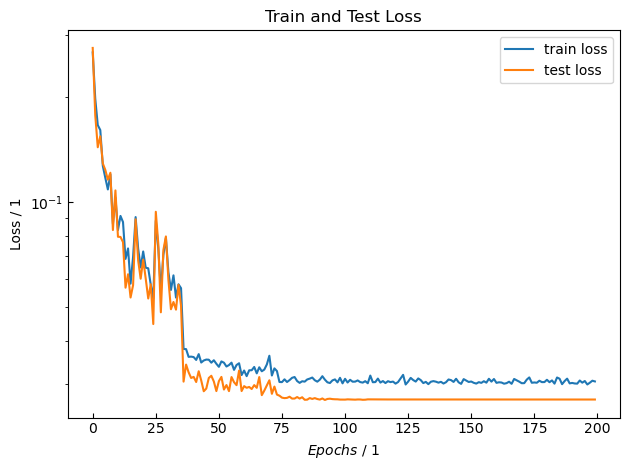

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Exportieren der Lernkurven zur Auswertung

In [11]:
np.savez('data/models/hyperparams/loss_005_007.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9983789262251223 , R^2(NH3) = 0.9884143013066176
Test Dataset: R^2(H2) = 0.9992178685532089 , R^2(NH3) = 0.9962393624450524
Max Error Training: |x_H2 - x_H2,pred| = 0.0642434125510114 , |x_NH3 - x_NH3,pred| = 0.10824030874499868
Max Error Test: |x_H2 - x_H2,pred| = 0.021806330486543235 , |x_NH3 - x_NH3,pred| = 0.032028696503834664


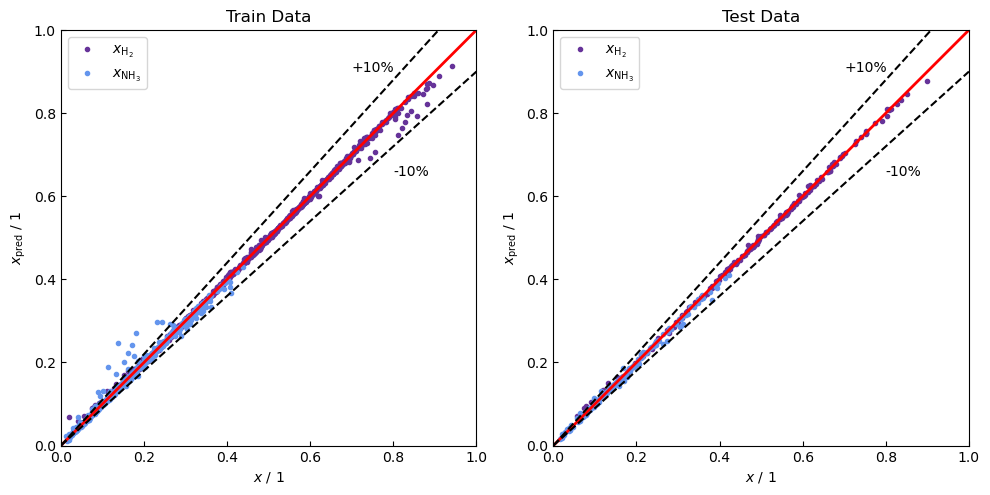

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

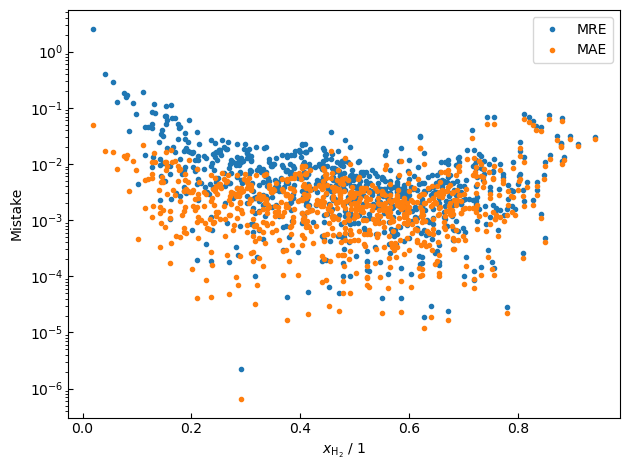

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

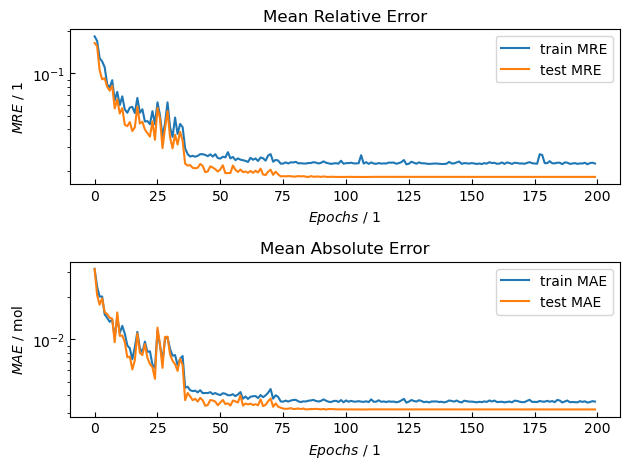

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

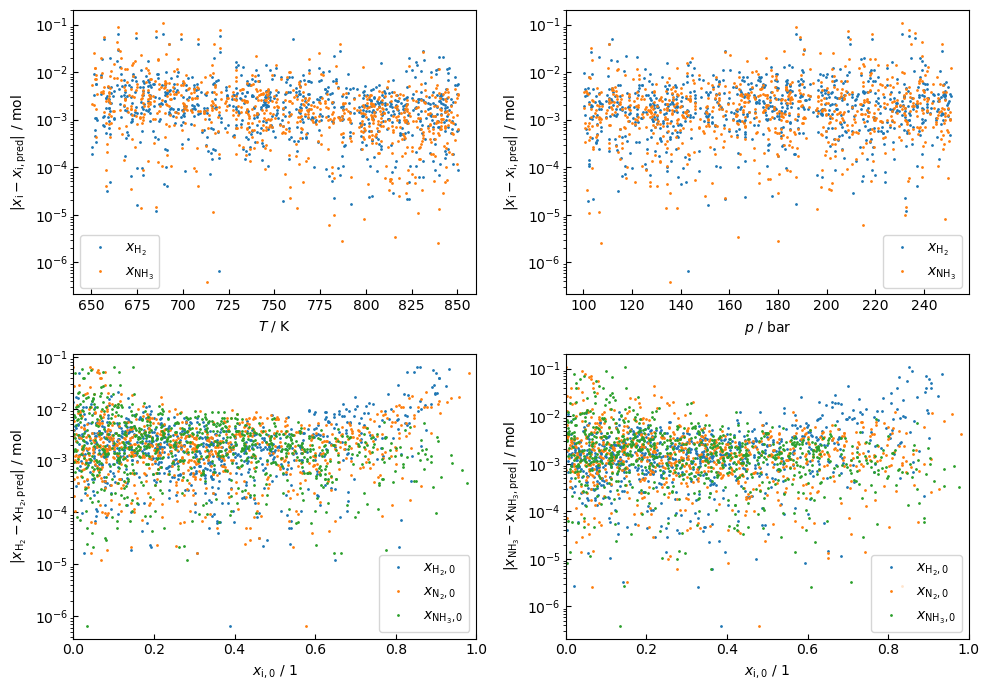

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

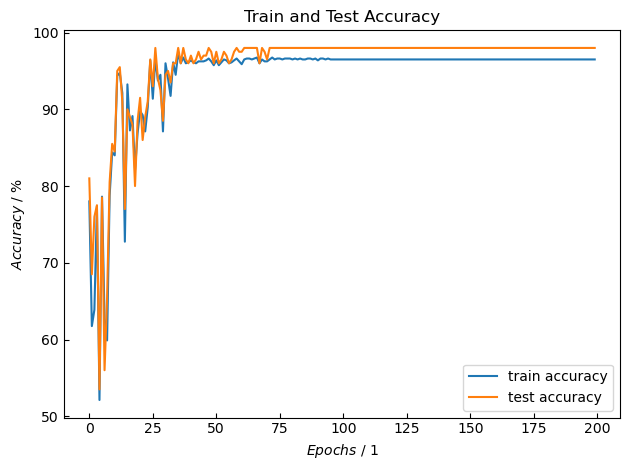

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.4753e+00, -1.0971e-01, -8.1232e-02, -1.2307e-01,  2.0551e-01],
        [ 1.5870e+00,  1.2557e+00, -4.1480e-01, -3.7189e-01,  7.8717e-01],
        [-1.1193e+00, -8.0417e-01, -7.0598e-01,  1.2467e+00, -5.8139e-01],
        [-1.1021e+00, -9.3551e-01, -1.3447e+00, -1.0576e+00,  2.4007e+00],
        [ 1.5312e+00,  1.1676e+00,  7.1824e-01, -1.0581e+00,  3.7663e-01],
        [-1.2474e+00, -1.0619e+00, -8.5798e-01,  1.4754e+00, -6.6591e-01],
        [ 1.1961e+00, -2.3495e-01,  1.6416e+00, -1.1335e+00, -4.5255e-01],
        [ 9.6685e-01,  9.9965e-01, -9.6235e-01,  1.2064e+00, -2.8858e-01],
        [-1.5485e+00,  2.6793e-01,  2.2703e+00, -1.2167e+00, -9.8440e-01],
        [-1.3295e+00, -3.4461e-01,  1.7009e+00, -6.7436e-01, -9.7998e-01],
        [ 9.0888e-01,  1.6511e+00,  1.4874e+00, -4.0854e-01, -1.0422e+00],
        [ 1.1662e-01, -8.4935e-01, -3.6919e-01,  1.6880e+00, -1.3630e+00],
        [-1.2213e-01, -1.2368e+00, -8.4085e-02,  1.0809e+00, -1.0223e+00],
        [-1.2146e-02, -9.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-2.9284e-01,  1.2361e-01,  3.1171e-03, -7.8669e-03,  4.4673e-01],
         [ 1.1660e-01,  4.7453e-03,  2.6451e-01, -6.0615e-01,  1.1256e-01],
         [-1.3025e-03, -1.6048e-03, -2.7564e-02, -2.8409e-02, -3.0101e-02],
         [ 1.3387e-01, -4.4255e-02, -2.3126e-01,  2.6453e-01,  1.8324e-01],
         [ 4.7236e-02, -5.6034e-02, -3.3848e-03,  7.4999e-02, -2.3021e-03],
         [-6.5995e-03,  1.2919e-02, -3.2136e-02, -6.6662e-03, -1.9619e-02],
         [-3.4621e-01,  9.2777e-02, -2.4736e-01, -2.8961e-01, -1.6319e-01],
         [-4.2322e-01,  2.0081e-01,  4.8805e-01, -5.3173e-01, -2.3947e-02],
         [-1.9395e-01,  3.2760e-01, -4.7332e-01,  1.8100e-01, -3.7557e-01],
         [-4.5195e-02, -1.4550e-01, -6.1784e-01,  3.5333e-01, -4.0290e-01],
         [-1.2807e-01, -1.8457e-01,  4.0196e-02,  1.8173e-01,  2.3379e-01],
         [ 5.1578e-02,  7.6617e-03,  2.8391e-01,  3.7852e-01,  2.7782e-01],
         [-5.5382e-02, -8.0560e-02, -9.5955e-02,  2.3320e-02, -2.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3994, 0.9324, 0.4806, 0.2026, 0.7321],
        [0.9564, 0.4982, 0.5728, 0.9855, 0.0249]])
tensor([[ 0.2181, -0.0430],
        [-0.1633, -0.6264]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 0.5499, -1.6670,  1.4947, -0.8963, -0.5508],
        [-1.0639, -0.1890, -1.3405, -0.2066,  1.5268],
        [ 0.1093, -0.2494,  1.4727, -0.1235, -1.3191],
        [ 1.4410, -1.2162,  2.4382, -1.2450, -1.1203],
        [ 0.7185,  0.6727,  0.0425, -1.2499,  1.2358],
        [ 0.3275,  0.9425, -1.2633,  1.1408,  0.0738],
        [ 0.9669,  0.9997, -0.9623,  1.2064, -0.2886],
        [-1.1362, -1.1689, -0.5023,  0.3184,  0.1675],
        [ 0.9027,  0.5931, -0.4091,  0.8752, -0.4931],
        [-1.3180, -1.2691, -0.9571,  0.9244, -0.0054],
        [-0.4710, -1.3299, -1.2395, -0.1318,  1.3511],
        [ 0.6416,  0.0905, -0.4138,  0.2182,  0.1831],
        [ 1.2557,  0.8361, -0.9591,  1.4409, -0.5315],
        [-0.4000,  0.5277,  1.2556, -1.3198,  0.1167],
        [ 0.1993, -0.4285,  0.7691, -0.3588, -0.3880],
        [-1.1075,  0.0340,  0.9834, -1.0437,  0.1016],
        [ 1.4046,  0.6345, -1.1961,  1.7900, -0.6557],
        [-0.4212,  0.1553, -1.1526, -1.1303,  2.2864],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()